# Singular Value

In [5]:
import sys
sys.path.insert(0, '../../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle as pkl
import tensorflow as tf

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from kraus_channels import KrausMap, DilutedKrausMap
from loss_functions import ProbabilityMSE, ProbabilityRValue, channel_fidelity_loss, SpectrumDistance
from optimization import ModelSPAM, ModelQuantumMap, Logger, model_saver
from quantum_channel import DilutedChannel, ChoiMapStatic
from quantum_tools import apply_unitary, measurement, resample, state_fidelity, generate_unitary, reshuffle
from experimental import counts_to_probs, generate_pauliInput_circuits, generate_pauli_circuits
from spam import SPAM, InitialState, POVMwQR as POVM, IdealPOVM, IdealInit, povm_fidelity, CorruptionMatrix
from synthetic_data import generate_spam_data, generate_map_data
from utils import saver, loader, train_val_split
from quantum_circuits import pqc_basic
from spectrum import channel_spectrum, mean_spacing


#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Non-Markovian

In [6]:
n = 4
d = 2**n

num_layer_list = [8, 16, 24,  32, 40, 56, 72, 88, 104, 120]


so_exp_list = []
so_DU_list = []


for num_layer in num_layer_list:
    model = pkl.load(open(f"models/L={num_layer}.model", "rb"))
    so = model[0].channel.superoperator
    so_exp_list.append(np.array(so))

    distance_best, model_best = pkl.load(open("models/" + f"diluted_fitting_KL_4qubit_{num_layer}layer.model", "rb"))
    so = model_best.channel.superoperator
    so_DU_list.append(np.array(so))

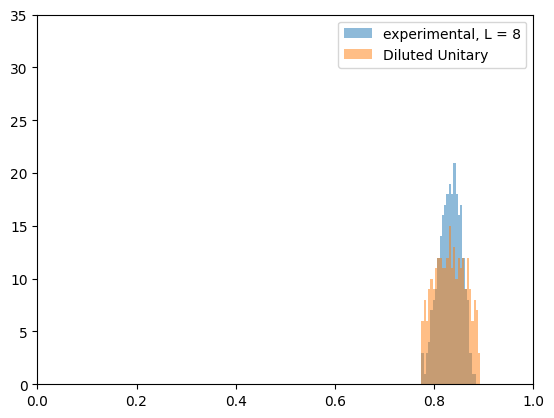

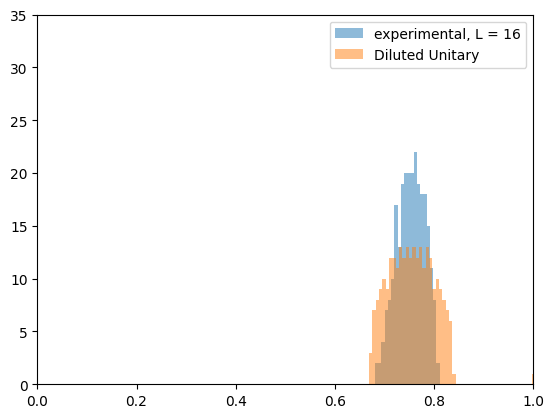

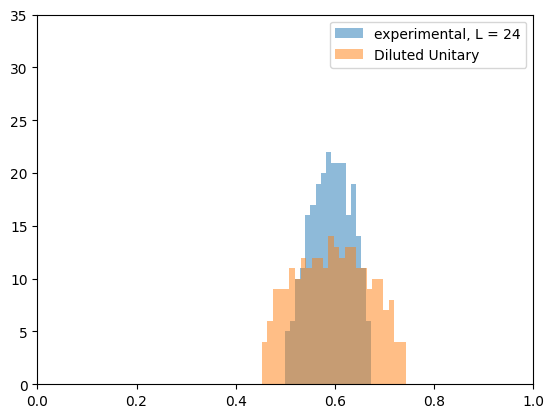

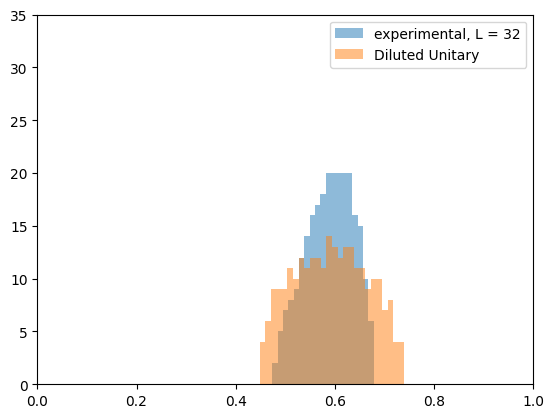

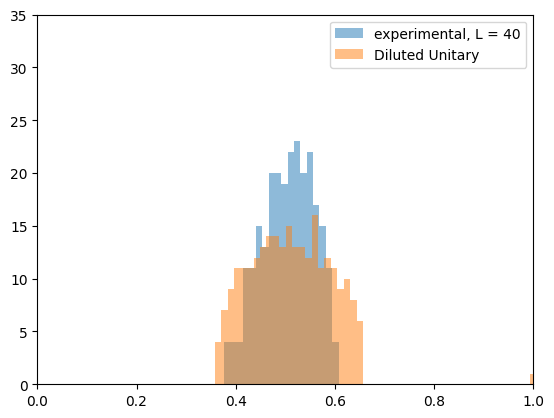

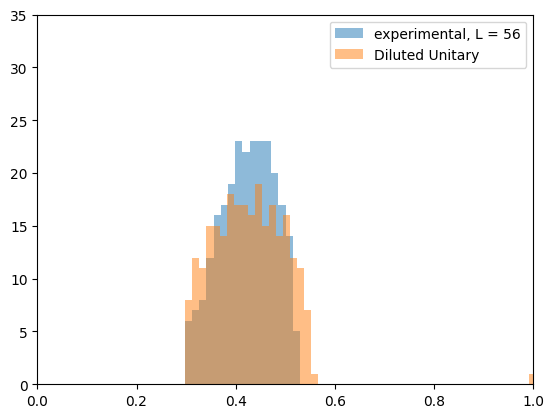

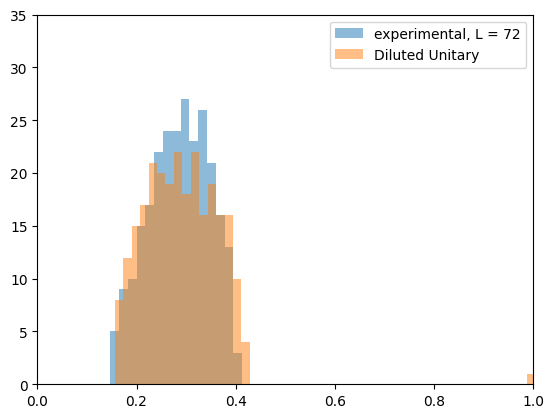

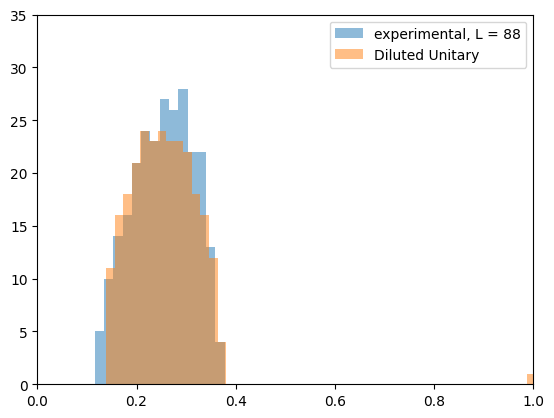

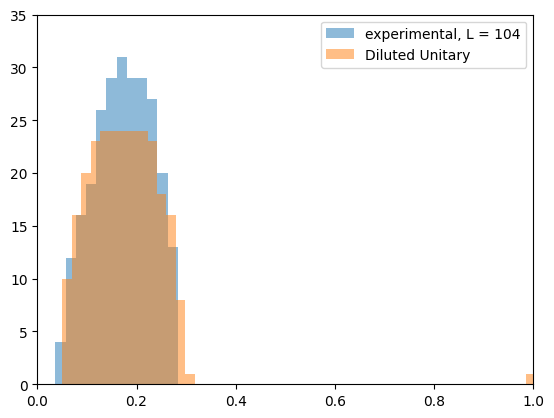

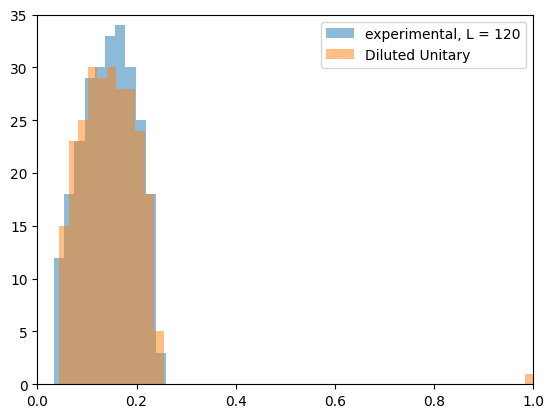

In [10]:
for so_exp, so_DU, num_layer in zip(so_exp_list, so_DU_list, num_layer_list):
    XX = so_exp@so_exp.T.conj()
    eig_exp = np.sqrt(np.linalg.eigvalsh(XX))
    np.savetxt(f"data/singular_spectrum/eig_exp_{num_layer}.txt", eig_exp)

    XX = so_DU@so_DU.T.conj()
    eig_DU = np.sqrt(np.linalg.eigvalsh(XX))
    np.savetxt(f"data/singular_spectrum/eig_DU_{num_layer}.txt", eig_DU)

    plt.hist(eig_exp, bins=50, alpha=0.5, label="experimental, L = " + str(num_layer))
    plt.hist(eig_DU, bins=50, alpha=0.5, label="Diluted Unitary")
    plt.xlim(0, 1)
    plt.ylim(0, 35)
    plt.legend()
    plt.show()